# Titanic survival prediction

## Description of the notebook 

This notebook is organized in 7 parts.

1. Data acquisition: we will import the dataset and get a first glance at what it contains.

2. Dataset exploratory analysis : we will analyze the data, get an understanding of the main features, of their types, if they have missing values...

3. Features exploratory analysis : we will analyze the data,find the corelation between the features and the survival rate and decide which features to keep

4. Data cleaning and feature selection : Select features that will be kept in the model and remove others, deal with missing values if there is any, create dummy variables for categories...

5. Model preparation : prepare the train and test set and prepare the models we will use for the classification

6. Pipeline evaluation and selection: We will run the models and get their scores, which will allow us the choose the best model.

7. Predict : Final stage, we will run our final model to execute predictions.

## 1. Data acquisition
In this part we will just import the relevant libraries and import the trainig and test datasets.
## Import libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
dataset_train = pd.read_csv("/kaggle/input/titanic/train.csv")
dataset_test = pd.read_csv("/kaggle/input/titanic/test.csv")

## 2. Dataset Exploratory analysis
In this section we will check the number and types of features for the dataset, if there is missing values, if there is corelation between some features, if we can remove some unnecessary features and if we can create new features from the ones we already have

In [3]:
def screen_data(df):
    rows = []
    for col in df.columns:
        rows.append([col, df[col].isnull().sum(), df[col].nunique(), df[col].dtypes])
    print(pd.DataFrame(rows, columns=['Col', 'Missing values', 'Unique values', 'Type']))

In [4]:
screen_data(dataset_train)

            Col  Missing values  Unique values     Type
0   PassengerId               0            891    int64
1      Survived               0              2    int64
2        Pclass               0              3    int64
3          Name               0            891   object
4           Sex               0              2   object
5           Age             177             88  float64
6         SibSp               0              7    int64
7         Parch               0              7    int64
8        Ticket               0            681   object
9          Fare               0            248  float64
10        Cabin             687            147   object
11     Embarked               2              3   object


In [5]:
screen_data(dataset_test)

            Col  Missing values  Unique values     Type
0   PassengerId               0            418    int64
1        Pclass               0              3    int64
2          Name               0            418   object
3           Sex               0              2   object
4           Age              86             79  float64
5         SibSp               0              7    int64
6         Parch               0              8    int64
7        Ticket               0            363   object
8          Fare               1            169  float64
9         Cabin             327             76   object
10     Embarked               0              3   object


## Preliminary infos we can get from the data screening
Here we can see that for dataset_train, three features have **missing data** (*age, cabin and embarked*)
For the dataset_test, there is also three features with **missing data** (*age, cabin and fare*)

We can also see that most features are **numerical** (*PassengerId, Survived, Pclass, Age, SibSP, ParCh and fare*) <br>
some are object type with **categories** (*Sex, Embarked*) <br>
and some are **string** (*Name, Ticket, cabin*) <br>

Cabin and age are missing a lot of value in both datasets, our exploratory analysis will tell us if we need to estimate the missing of value or if we can drop these features.

Now let's print some rows from the dataset

In [6]:
dataset_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
dataset_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Preliminary infos we can get from the data
- The passengerId probably does not give any information on the survivability. <br>
- There is always a title in the name column which might give us further information. <br>
- Some people have a non round age, we will see what to do about it. <br>
- The cabin seems to have a letter associated with it, we might extract to see if it can be link to survivability. <br>

Let's see if we can bet any additional infos about the numerical data.

In [8]:
dataset_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Preliminary infos we can get from the numerical data
- The average survival rate is 38%. <br>
- More than 50% of the passengers are in the Pclass number 3. <br>
- Most passengers are between 20 and 40 years old with the minimum being 0.42 and the maximum being 80 years old. <br>
- More than 50% of the passengers travel alone (0 in SibSp and Parch). <br>
- The minimum fare is 0 which might be an error and the maximum is 512 with is also and extreme value considering a mean value of 32 and a std of 50. <br>

Let's see if we can bet any additional infos about the correlation of the data.

In [9]:
dataset_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


## Preliminary infos we can get from the correlation matrix
- The passengerId is not correlated to the survivability which confirms our hypothesis. <br>
- The pclass is correlated negatively to the survivability, which means people in class 1 survived better than people in class 3. <br>
- The fare is correlated positively to the survivability, which means people that paid a higher fare had a better chance of surviving. <br>
- The age is not correlated to survivability which is surprising, we would have imagined that younger persons would have survived better than older ones. Maybe it is correlated but not in a linear way. <br>

Let's see if we can bet any additional infos about the repartition of the data.

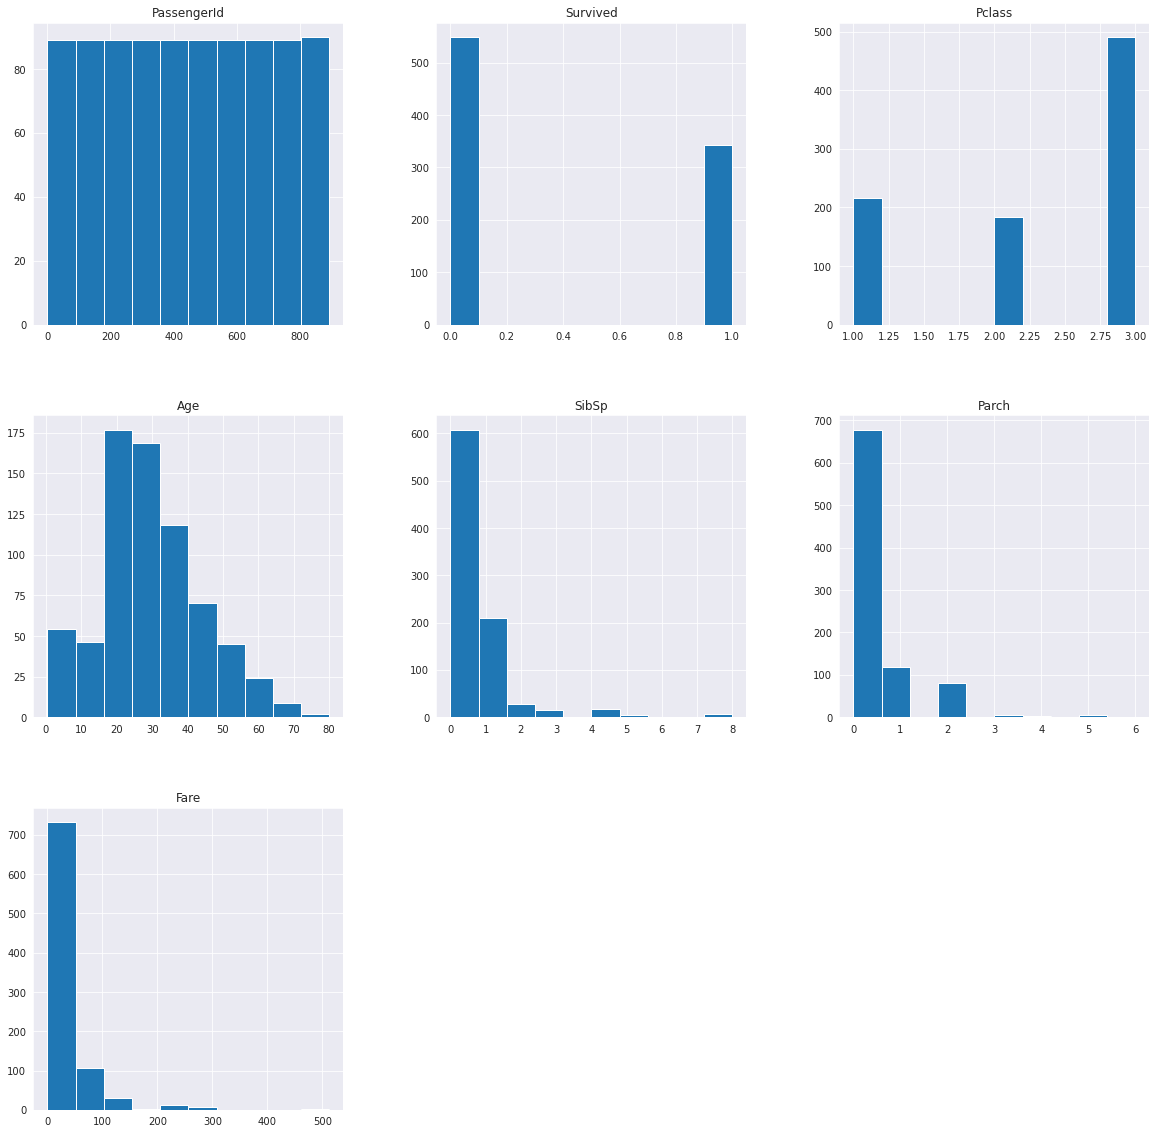

In [10]:
#dataset_train.plot(kind='density', subplots=True, layout=(4,2), sharex=False, figsize=(20,20))
dataset_train.hist(figsize=(20,20));

## Preliminary infos we can get from the histogram plots
- Most people traveled alone. <br>
- Most people paid a fare less than $50. <br>
- There is some very young children amongst the passengers. <br>
- There is approximately the same amount of passengers in class 1 and 2. <br>

Let's dive now a bit further in the features and how they affect the survival rate.

## 3. Feature exploratory analysis

What we would like to analyse :
- The correlation of age and survivability
- The correlation of sex and survivability
- The correlation of the port of embarquation and survivability
- Does the number of siblings or parents/children has an impact on survivability.
- Who paid 0 and $512 for their ticket?

# START FROM HERE

Let's look at the two features with categories (sex and embarked)

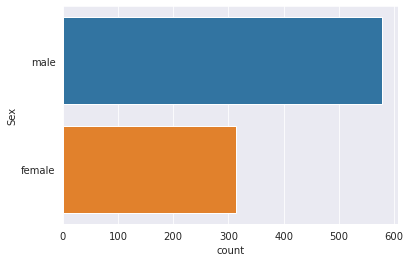

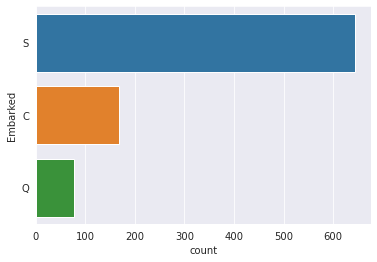

In [11]:
for column in dataset_train.select_dtypes(include='object'):
    if dataset_train[column].nunique() < 10:
        sns.countplot(y=column, data=dataset_train)
        plt.show()

There is a more men than women and most of the passengers embarked at the Southampton port.

Now let's check if the features have an impoact on the survival rate.

**Does sex and class have an impact on survival rate?**

In [12]:
dataset_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
dataset_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival rate vs Pclass and sex')

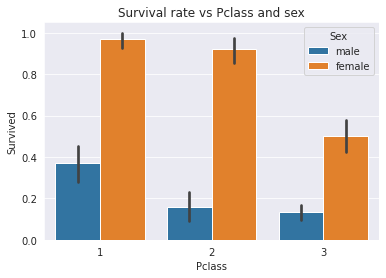

In [14]:
ax = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=dataset_train)
ax.set_title('Survival rate vs Pclass and sex')

Women had a better survival rate that men and a higher class meant more chance of surviving

**Does the port has an importance?**

In [15]:
dataset_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival rate vs port and sex')

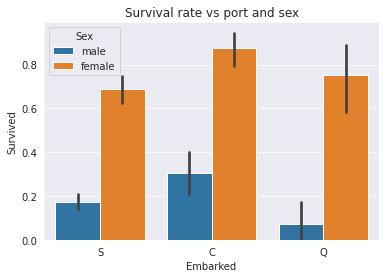

In [16]:
ax = sns.barplot(x="Embarked", y="Survived", hue="Sex", data=dataset_train)
ax.set_title('Survival rate vs port and sex')

The port has an importance.

**Does the number of siblings or spouse (SibSp) or parents and children (Parch) has an importance?**

In [17]:
dataset_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Text(0.5, 1.0, 'Survival rate vs SibSp and sex')

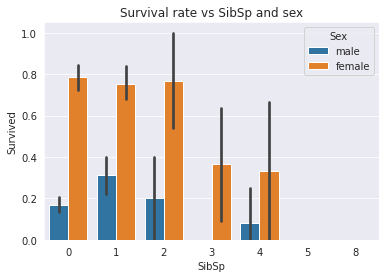

In [18]:
ax = sns.barplot(x="SibSp", y="Survived", hue="Sex", data=dataset_train)
ax.set_title('Survival rate vs SibSp and sex')

In [19]:
dataset_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival rate vs Parch and sex')

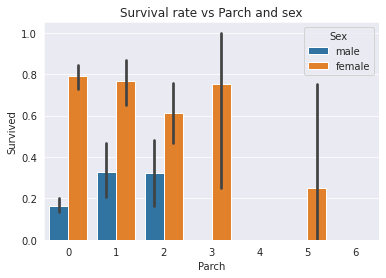

In [20]:
ax = sns.barplot(x="Parch", y="Survived", hue="Sex", data=dataset_train)
ax.set_title('Survival rate vs Parch and sex')

Both Sibsp and Parch seem to be important to estimate the survival rate of a passenger.

**Let's see if the age impacts the rate of survival**

<AxesSubplot:xlabel='Age', ylabel='Count'>

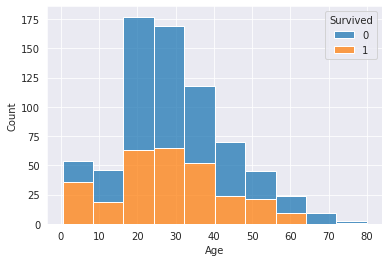

In [21]:
sns.histplot(data=dataset_train, x="Age", hue="Survived", multiple="stack", bins=10)

Text(0.5, 1.0, 'Survival rate vs Pclass and sex')

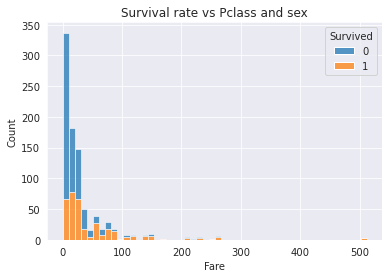

In [22]:
ax = sns.histplot(data=dataset_train, x='Fare', hue="Survived", multiple="stack", bins=50)
ax.set_title('Survival rate vs Pclass and sex')

## 4. Data cleaning and feature selection

**Let's fill missing data for fare.**
**Let's create fare groups to display them more easily.**

In [23]:
combine = [dataset_train, dataset_test]

In [24]:
for dataset in combine:    
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('C')
    dataset.loc[dataset['Fare'] == 0, 'Fare'] = dataset['Fare'].median()
    dataset.loc[ dataset['Fare'] <= 10, 'Fare_class'] = "Very cheap"
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 50), 'Fare_class'] = "Cheap"
    dataset.loc[(dataset['Fare'] > 50) & (dataset['Fare'] <= 100), 'Fare_class'] = "Expensive"
    dataset.loc[ dataset['Fare'] > 100, 'Fare_class'] = "Very expensive"
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    dataset.loc[ dataset['Age'] <= 16, 'Age_category'] = "children"
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 35), 'Age_category'] = "young_adults"
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 50), 'Age_category'] = "adults"
    dataset.loc[(dataset['Age'] > 50), 'Age_category'] = "senior"
    dataset['Sex'] = dataset['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
    dataset['Family'] = dataset['Parch']+dataset['SibSp']
    dataset.loc[ dataset['Family'] < 1, 'Family'] = 0
    dataset.loc[ dataset['Family'] >= 1, 'Family'] = 1
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Cabin'] = dataset['Cabin'].astype(str).str[0]
    
dataset_train = dataset_train.drop(columns=['PassengerId', 'Ticket','Name'])
dataset_test = dataset_test.drop(columns=['PassengerId', 'Ticket','Name'])
dataset_train = dataset_train.drop(columns=['SibSp','Parch', 'Age', 'Fare'])
dataset_test = dataset_test.drop(columns=['SibSp','Parch', 'Age', 'Fare'])

In [25]:
dataset_train

,Survived,Pclass,Sex,Cabin,Embarked,Fare_class,Age_category,Family,Title
0,0,3,0,n,S,Very cheap,young_adults,1,Mr
1,1,1,1,C,C,Expensive,adults,1,Mrs
2,1,3,1,n,S,Very cheap,young_adults,0,Miss
3,1,1,1,C,S,Expensive,young_adults,1,Mrs
4,0,3,0,n,S,Very cheap,young_adults,0,Mr
...,...,...,...,...,...,...,...,...,...
886,0,2,0,n,S,Cheap,young_adults,0,Rare
887,1,1,1,B,S,Cheap,young_adults,0,Miss
888,0,3,1,n,S,Cheap,young_adults,1,Miss
889,1,1,0,C,C,Cheap,young_adults,0,Mr


In [26]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        418 non-null    int64 
 1   Sex           418 non-null    int64 
 2   Cabin         418 non-null    object
 3   Embarked      418 non-null    object
 4   Fare_class    418 non-null    object
 5   Age_category  418 non-null    object
 6   Family        418 non-null    int64 
 7   Title         418 non-null    object
dtypes: int64(3), object(5)
memory usage: 26.2+ KB


In [27]:
encode_col_list = list(dataset_train.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    dataset_train = pd.concat([dataset_train,pd.get_dummies(dataset_train[i], prefix=i)],axis=1)
    dataset_train.drop(i, axis = 1, inplace=True)
    
encode_col_list = list(dataset_test.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    dataset_test = pd.concat([dataset_test,pd.get_dummies(dataset_test[i], prefix=i)],axis=1)
    dataset_test.drop(i, axis = 1, inplace=True)

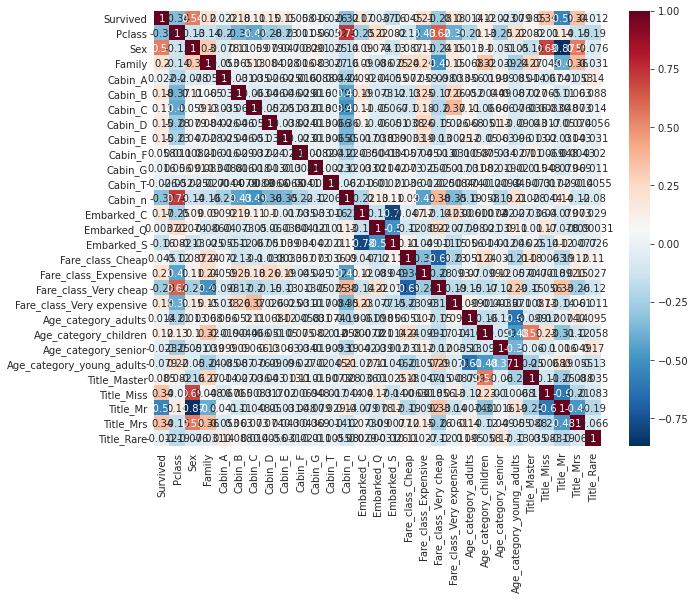

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(dataset_train.corr(), cmap='RdBu_r', annot=True)
plt.show()

In [29]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Pclass                     418 non-null    int64
 1   Sex                        418 non-null    int64
 2   Family                     418 non-null    int64
 3   Cabin_A                    418 non-null    uint8
 4   Cabin_B                    418 non-null    uint8
 5   Cabin_C                    418 non-null    uint8
 6   Cabin_D                    418 non-null    uint8
 7   Cabin_E                    418 non-null    uint8
 8   Cabin_F                    418 non-null    uint8
 9   Cabin_G                    418 non-null    uint8
 10  Cabin_n                    418 non-null    uint8
 11  Embarked_C                 418 non-null    uint8
 12  Embarked_Q                 418 non-null    uint8
 13  Embarked_S                 418 non-null    uint8
 14  Fare_class_Cheap          

Let's try to fill the missing age values with a multiple linear regression algorithm 

In [30]:
#dataset_test['Survived'] = np.array([np.linspace(-1,-1,418)]).T
#full_dataset = pd.concat(combine)
#full_dataset.info()

Let's fill the missing values from Fare and Embarked with the median value and drop the name, Ticket and cabin

In [31]:
#full_dataset['Fare'] = full_dataset['Fare'].fillna(full_dataset['Fare'].median())
#full_dataset['Embarked'] = full_dataset['Embarked'].fillna('C')
#full_dataset['Age'] = full_dataset['Age'].fillna(-1)
#full_dataset['Embarked'] = full_dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
#full_dataset['Sex'] = full_dataset['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
#full_dataset = full_dataset.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
#full_dataset.info()

In [32]:
#df_age = full_dataset.drop(columns=['Survived'])
#df_age.info()

In [33]:
#df_age_to_predict = df_age[df_age['Age'] < 0]
#df_age = df_age[df_age['Age'] >= 0]

In [34]:
#X = df_age.drop(columns=['Age'])
#y = df_age.iloc[:, 2].values
#X_pred = df_age_to_predict.drop(columns=['Age'])
#y = np.array([y]).T
#print(y)

In [35]:
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#regressor = LinearRegression()
#regressor.fit(X_train, y_train)

#y_pred_linear_regression = regressor.predict(X_test)
#np.set_printoptions(precision=2)
#print(np.concatenate((y_pred_linear_regression.reshape(len(y_pred_linear_regression),1), y_test.reshape(len(y_test),1)),1))

#from sklearn.tree import DecisionTreeRegressor
#regressor_decision_tree = DecisionTreeRegressor(random_state = 0)
#regressor_decision_tree.fit(X_train, y_train)

#y_pred_decision_tree = regressor_decision_tree.predict(X_test)
#np.set_printoptions(precision=2)
#print(np.concatenate((y_pred_decision_tree.reshape(len(y_pred_decision_tree),1), y_test.reshape(len(y_test),1)),1))

#from sklearn.ensemble import RandomForestRegressor
#regressor_random_forest = RandomForestRegressor(n_estimators = 10, random_state = 0)
#regressor_random_forest.fit(X_train, y_train)

#y_pred_random_forest = regressor_random_forest.predict(X_test)
#np.set_printoptions(precision=2)
#print(np.concatenate((y_pred_random_forest.reshape(len(y_pred_random_forest),1), y_test.reshape(len(y_test),1)),1))

#from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error
#data = [['Multiple linear regression', r2_score(y_test, y_pred_linear_regression), max_error(y_test, y_pred_linear_regression), mean_absolute_error(y_test, y_pred_linear_regression), mean_squared_error(y_test, y_pred_linear_regression)],
#['Polynomial regression', r2_score(y_test, y_pred_polynomial_regression), max_error(y_test, y_pred_polynomial_regression), mean_absolute_error(y_test, y_pred_polynomial_regression), mean_squared_error(y_test, y_pred_polynomial_regression)],
#['Decision tree', r2_score(y_test, y_pred_decision_tree), max_error(y_test, y_pred_decision_tree), mean_absolute_error(y_test, y_pred_decision_tree), mean_squared_error(y_test, y_pred_decision_tree)],
#['Random forest regression', r2_score(y_test, y_pred_random_forest), max_error(y_test, y_pred_random_forest), mean_absolute_error(y_test, y_pred_random_forest), mean_squared_error(y_test, y_pred_random_forest)]] 
#headers_1=["1", "2", "3", "4"] 
#headers_2=["Algorithm", "R² score", "Max error", "Mean absolute error", "Mean squared error"] 
#print(pd.DataFrame(data, headers_1, headers_2))


#y_pred = regressor.predict(X_pred)
#y_pred = np.array(y_pred)
#print(y_pred)

#full_dataset.loc[full_dataset['Age'] < 0, 'Age'] = y_pred
#print(full_dataset)

#X = full_dataset[full_dataset['Survived'] != -1]
#y = X['Survived']
#X = X.drop(columns=['Survived'])
#y = np.array([y]).T
#X_pred = full_dataset[full_dataset['Survived'] == -1]
#X_pred = X_pred.drop(columns=['Survived'])

## 5. Model Preparation

In [36]:
X = dataset_train.drop(columns=['Survived'])
y = np.ravel(np.array([dataset_train['Survived']]).T)

X_pred = dataset_test

folds = KFold(n_splits=10, shuffle=True, random_state=0)

In [37]:
missing_columns = set(X.columns.to_list()) - set(X_pred.columns.to_list())
for col in list(missing_columns):
    X_pred[col] = 0

In [38]:
logreg = LogisticRegression();
cv_score = cross_val_score(logreg, X, y,cv=folds);
logreg.fit(X, y)
print('Accuracy : ', round(cv_score.mean()*100,2), '%')
print('Standard deviation : ', round(cv_score.std()*100,2), '%')

Accuracy :  80.24 %
Standard deviation :  3.17 %


In [39]:
knn = KNeighborsClassifier(n_neighbors = 5)
cv_score = cross_val_score(knn, X, y,cv=folds);
print('Accuracy : ', round(cv_score.mean()*100,2), '%')
print('Standard deviation : ', round(cv_score.std()*100,2), '%')

Accuracy :  77.33 %
Standard deviation :  7.26 %


In [40]:
decision_tree = DecisionTreeClassifier()
cv_score = cross_val_score(decision_tree, X, y,cv=folds);
print('Accuracy : ', round(cv_score.mean()*100,2), '%')
print('Standard deviation : ', round(cv_score.std()*100,2), '%')

Accuracy :  80.25 %
Standard deviation :  2.51 %


In [41]:
random_forest = RandomForestClassifier(n_estimators=100)
cv_score = cross_val_score(random_forest, X, y,cv=folds);
print('Accuracy : ', round(cv_score.mean()*100,2), '%')
print('Standard deviation : ', round(cv_score.std()*100,2), '%')

Accuracy :  80.81 %
Standard deviation :  1.72 %


In [42]:
rfc=RandomForestClassifier(random_state=0)
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,4,10],
    'criterion' :['gini', 'entropy']
}
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train, y_train)
#CV_rfc.best_params_

In [43]:
#grid_search_cv = GridSearchCV(rfc, param_grid, verbose=10, cv=10)
#grid_search_cv.fit(X, y)
#grid_search_cv.best_params_

In [44]:
rfc1=RandomForestClassifier(random_state=0, max_features='log2', n_estimators= 200, min_samples_split=2, criterion='entropy')
cv_score = cross_val_score(rfc1, X, y,cv=folds);
print('Accuracy : ', round(cv_score.mean()*100,2), '%')
print('Standard deviation : ', round(cv_score.std()*100,2), '%')

Accuracy :  81.93 %
Standard deviation :  2.88 %


In [45]:
#dt1=DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=4, max_leaf_nodes=15, min_samples_split= 2)
#dt1.fit(X_train, y_train)
#print(round(rfc1.score(X_test, y_test) * 100, 2))

In [46]:
rfc1.fit(X,y)
y_pred = rfc1.predict(X_pred).astype(int)
output = pd.DataFrame({'PassengerId': pd.read_csv("/kaggle/input/titanic/test.csv").PassengerId, 'Survived': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [47]:
#plt.figure(figsize=(10,8))
#sns.heatmap(X_train.corr(), cmap='RdBu_r', annot=True)
#plt.show()